In [1]:
from utils import *
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Segoe UI Symbol','simHei','Arial','sans-serif']

## Load Data

In [2]:
years = [2016,2017]
resampling_period = '60T'  # 60 minutes

original_data = load_resample_data(years, resampling_period)
windfarms_names = original_data.columns.tolist()    

year:2016	(105408, 20)
year:2017	(105120, 20)
resampled to  (17544, 20)


### Normalize data = Capacity Factor (optional) 

In [3]:
windfarms = pd.read_excel('NRGstreamData/WindFarms.xlsx').sort_values(by='Asset ID').reset_index(drop = True)
# windfarms.head(4)
normalized_data = original_data / windfarms['Capacity'].values
# normalized_data.head(4)

## Clustering (optional)

In [4]:
# from sklearn.cluster import KMeans
n_clusters = 5
# kmin = KMeans(n_clusters)
# X = np.transpose(normalized_data.iloc[:,:])
# Y = kmin.fit(X)
# clusters = kmin.labels_
# clusters

clusters = np.array([1, 1, 2, 1, 4, 4, 0, 0, 0, 1, 3, 0, 0, 0, 3, 0, 1, 2, 3, 2])

a = {}
for c in range(n_clusters):
    ind = clusters == c # OR: ind = np.where(clusters==c)[0] --> this generate an np.array of only indices
    # a[c] = (normalized_data.iloc[:,ind]).mean(axis=1) : old version
    a[c] = (original_data.iloc[:,ind]).sum(axis=1) / (windfarms['Capacity'].iloc[ind].sum())
    

clustered_data = pd.DataFrame.from_dict(a)
clustered_data.columns = ['Cluster {:d}'.format(d) for d in range(1,n_clusters+1)] 

sum_capacities_each_row = [sum(~(original_data.iloc[i,:].isnull().values) * 
                                 windfarms['Capacity'].values) for i in range(0,original_data.shape[0])]
clustered_data['Total'] = original_data.sum(axis=1)/ sum_capacities_each_row
# clustered_data['Total'] = clustered_data.mean(axis=1)
# clustered_data.head(4)

### Decide what data to use for further analysis (Original data | Normalized data | clustered_data)

In [5]:
# #### Be catious !
data = clustered_data  # Normalized_data  | Original_data
data.head()

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Total
DT,,,,,,
2016-01-01 00:00:00,0.69,0.84,0.30,0.88,0.79,0.66
2016-01-01 01:00:00,0.66,0.73,0.37,0.91,0.80,0.65
2016-01-01 02:00:00,0.62,0.70,0.36,0.90,0.75,0.63
2016-01-01 03:00:00,0.55,0.72,0.44,0.85,0.72,0.62
2016-01-01 04:00:00,0.57,0.73,0.52,0.79,0.71,0.64


## Convert original numerical data into categorical representation

In [6]:
alphabet_size = 5
alphabets = list(string.ascii_uppercase[:alphabet_size]) # ['A', 'B', 'C', 'D', 'E' , ...]
alphabets = [ "○" , '◔', '◑', '◕', "●"] #  "○" , '◔', '◑', '◕', "●"  OR '▁ ','▃ ', '▄ ', '▆ ', '█ '

categorical_reps_df = categorical_rep_mycode_df(data.iloc[:,-20:],data.columns, alphabet_size, alphabets)
categorical_reps_df.head(4)

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Total
DT,,,,,,
2016-01-01 00:00:00,◕,●,◔,●,◕,◕
2016-01-01 01:00:00,◕,◕,◔,●,●,◕
2016-01-01 02:00:00,◕,◕,◔,●,◕,◕
2016-01-01 03:00:00,◑,◕,◑,●,◕,◕


In [7]:
# Very slow: Do not run
# categorical_reps = categorical_rep_mycode(data.iloc[:,-20:],alphabet_size)
# t = time.time()dd
# kk = [  ''.join(categorical_reps.loc[j][0][i] for j in range(20)) for i in range(L)]
# time.time() - t

In [8]:
categorical_reps_joined = categorical_reps_df.iloc[:,:-1].apply(lambda x: ''.join(x), axis = 1)
categorical_reps_joined.head(5)

DT
2016-01-01 00:00:00    ◕●◔●◕
2016-01-01 01:00:00    ◕◕◔●●
2016-01-01 02:00:00    ◕◕◔●◕
2016-01-01 03:00:00    ◑◕◑●◕
2016-01-01 04:00:00    ◑◕◑◕◕
Freq: 60T, dtype: object

In [9]:
def co_occurrence_matrix(series1,series2,alphabets):
    """
    This functon computes the probabilty of all pairwise possible combination of occurance of two series; 
    Return: a matrix with size n_alphabets * n_alphabets, where each element shows the propobilty; sum of all elements of this
    matrix is 1.
    """
    patterns = list(product(alphabets,alphabets))
    categorical_reps = np.stack([series1,series2],axis=1)
    
    c = prob_occ_patterns_in_few_series(patterns,categorical_reps)
    c = c.reshape(len(alphabets),-1)
    
    return c

In [10]:
def prob_occ_patterns_in_few_series(patterns,categorical_reps_here):
    patterns = np.array(patterns)
    categorical_reps_here = np.array(categorical_reps_here)
    
    n_series = categorical_reps_here.shape[1]
    assert (patterns.shape[1] == n_series), "Length of Pattern should be the same as number of series"

    prob_co_occurrence_series=[]
    for row in range(patterns.shape[0]):
        pat = patterns[row,:]

        a = []    
        for i in range(n_series):
            p = pat[i]
            arr = categorical_reps_here[:,i]
            a.append(arr==p)
    
        a =  np.array(a)
        a = sum(a.prod(axis=0)) / len(arr)
        

        
        prob_co_occurrence_series.append(a)
    
    prob_co_occurrence_series = np.array(prob_co_occurrence_series)
    return prob_co_occurrence_series    

In [11]:
def calc_joint_probabilties_many_time_series(data, series_lower_upper_range):
    n_series = data.shape[1]
    
    a = []    
    for i in range(n_series):
        a.append(data.iloc[:,i].values >= series_lower_upper_range[i][0])
        a.append(data.iloc[:,i].values <= series_lower_upper_range[i][1])
        # OR np.logical_and(data.iloc[:,i].values <= series_lower_upper_range[i][1]) & ...) : This is slower

    # print(a)
    a = np.array(a)
    prob = np.mean(a.prod(axis=0))
    
    return np.round(prob,6)

In [12]:
series_lower_upper_range = [(0.6,0.8),(0.8,1)]
calc_joint_probabilties_many_time_series(data.iloc[:,0:2], series_lower_upper_range)

0.051357

In [13]:
categorical_reps_here = np.array(categorical_reps_df.iloc[:,[0,1]])

# first method
patterns_here = list(product(alphabets,alphabets))
c = prob_occ_patterns_in_few_series(patterns_here,categorical_reps_here) 
c = c.reshape(len(alphabets),-1)

# second method
c2 = co_occurrence_matrix(categorical_reps_here[:,0],categorical_reps_here[:,1],alphabets)

c2 == c
c

array([[0.44305746, 0.05283858, 0.01516188, 0.00495896, 0.00079799],
       [0.03368673, 0.03317373, 0.02667579, 0.01151391, 0.00330597],
       [0.01316689, 0.02325581, 0.02713178, 0.0251368 , 0.0124259 ],
       [0.00581395, 0.0120839 , 0.02285682, 0.04081167, 0.05135659],
       [0.00102599, 0.00410397, 0.00746694, 0.02314181, 0.10505016]])

In [71]:
n_pair_clusters = [2,3,4,5]

probs = {}
combs = []

for npc in n_pair_clusters:
    patterns_here = [alphabets[-1]] * npc 
    patterns_here = np.expand_dims(patterns_here,axis=0) 
    comb = list(itertools.combinations(range(n_clusters),npc))
    combs.extend(comb)
    
    for c in comb:
        categorical_reps_here = np.array(categorical_reps_df.iloc[:,list(c)])
        # probs.append(prob_occ_patterns_in_few_series(patterns_here ,categorical_reps_here))
        key = (np.array(c)+1)
        key = '-'.join(map(str,key))
        probs[key]=prob_occ_patterns_in_few_series(patterns_here ,categorical_reps_here)
# probs
print(patterns_here)

[['●' '●' '●' '●' '●']]


In [72]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Segoe UI Symbol','simHei','Arial','sans-serif']

probs_df = pd.DataFrame.from_dict(probs, orient='index')
probs_df.rename(columns={ 0:'Probabilty'}, inplace=True)

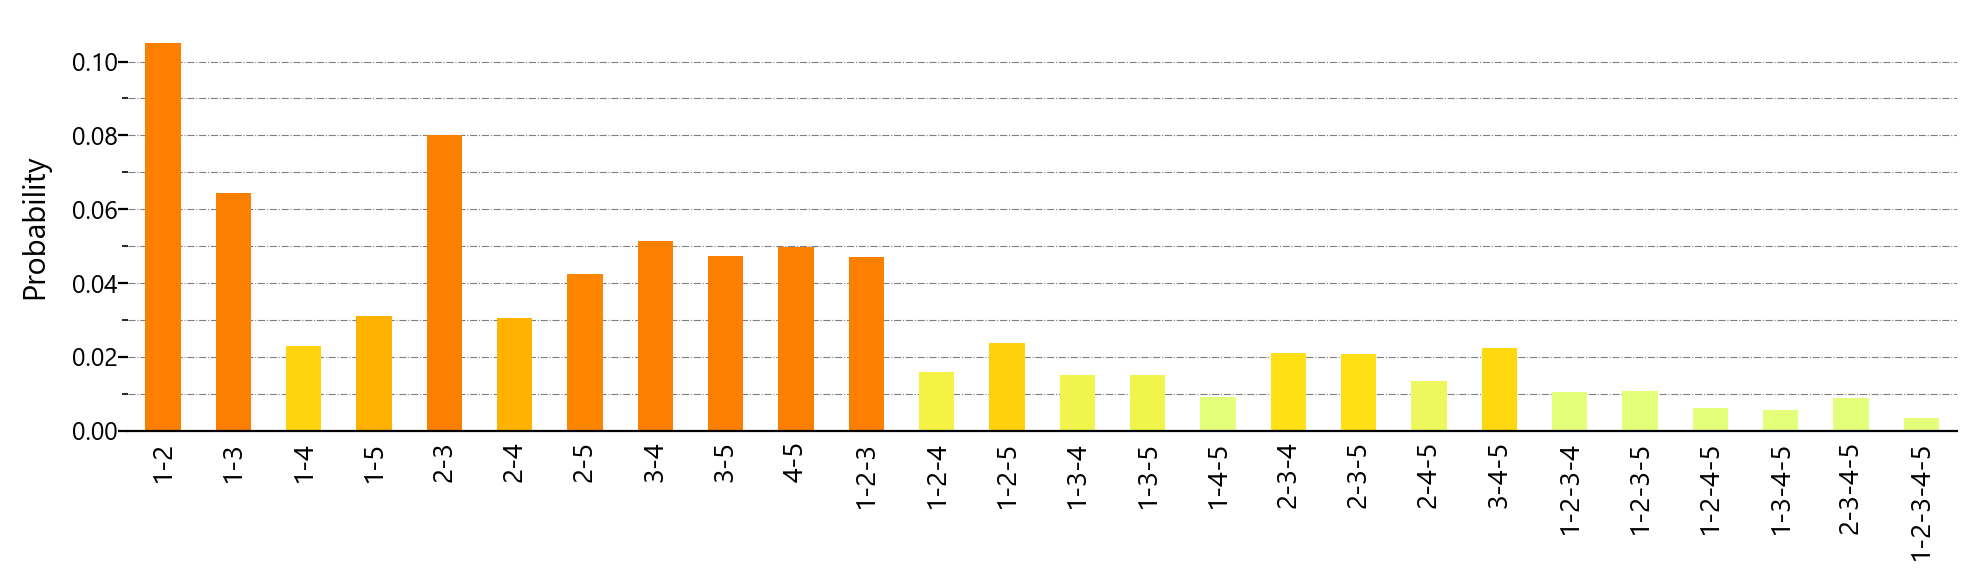

In [77]:
data_here = probs_df
fig, ax = plt.subplots(figsize=(10,3), dpi = 200)
data_here.plot(kind='bar', ax= ax, legend = False, color = '#454545')

ax.tick_params(axis='x', labelsize = 10, which='both', pad=0, rotation=90 , color = 'w')
ax.tick_params(axis='y', labelsize = 9, which='both', pad=0, rotation=0 , color = 'k')
# ax.set_yticks(np.arange(0,0.45,0.05),minor=True)
ax.set_yticks(np.arange(0,0.11,0.01),minor=True)
# ax.set_yticklabels(labels=[1,4,7,9,9,0],minor=True)
# ax.set_xlabel('Joint clusters',fontsize=12, color = 'darkgreen')
ax.set_ylabel("Probability",fontsize=11,labelpad=8) #of joint operation at \n very low capacity factor
ax.grid(color='k', linestyle='-.', linewidth=0.4, alpha = 0.5, which = 'minor')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

fracs = data_here.values / (ax.get_ylim()[1]/2)
# fracs[0] = fracs[1]
# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(0.2, 0.8)
# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, ax.patches):
    color = np.array(plt.cm.Wistia(norm(thisfrac[0])))
    thispatch.set_facecolor(color)


ax.set_axisbelow(True)
fig.tight_layout()

fig.savefig('Probability_of_joint_operation_of_clusters_at_very_high_CF.jpg', dpi = 300, bbox_inches='tight')    

### Find the most frequent patterns of a set of time series

In [16]:
Frequent_patterns = find_most_frequent_patterns_set_timeseries(categorical_reps_joined)
Frequent_patterns.head(10)
prob_frequent_patterns = Frequent_patterns/(data.shape[0] )
prob_frequent_patterns.head(10)

,Frequency
Pattern,
○○○○○,0.13
○○○○◔,0.03
○○○○◑,0.02
○○○◔○,0.02
○○◔○○,0.01
○○○◔◔,0.01
○○○◔◕,0.01
○○○○◕,0.01
○○○◔◑,0.01


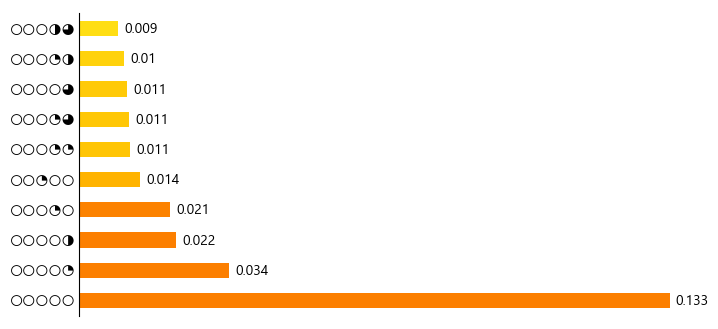

In [23]:
from matplotlib import colors
data_here = prob_frequent_patterns.iloc[0:10,:]
fig, ax = plt.subplots(1, 1,figsize=(8,4), dpi=100)
ax = data_here.plot(kind='barh', ax = ax, legend = False, color='#454545')
        
margin = 0.01 * ax.get_xlim()[1]
for i in ax.patches:
    ax.text(i.get_width() + margin , i.get_y() + 0.1, \
            str(round((i.get_width()), 3)))

# ax.tick_params(axis='x', labelsize = 10, which='major', pad=0, rotation=0 , color = 'w')
ax.tick_params(axis='y', labelsize = 11, which='major', pad=-1, rotation=0 , color = 'w')
# # ax.set_xlabel('Probability of the pattern',fontsize=12, color = 'navy')
ax.set_ylabel('',fontsize=11)
ax.get_xaxis().set_visible(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

fracs = data_here.values / (ax.get_xlim()[1] / 4)
# fracs[0] = fracs[1]
# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(0.1, 0.6)
# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, ax.patches):
    color = np.array(plt.cm.Wistia(norm(thisfrac[0])))
    thispatch.set_facecolor(color)


fig.savefig('Most_frequent_patterns_of_joint_operation_of_clustered_windfarms.jpg', dpi = 300, bbox_inches='tight')    

In [18]:
prob_frequent_patterns.iloc[0:10,:].values

array([[0.13332193],
       [0.03380073],
       [0.02194482],
       [0.02063383],
       [0.01379389],
       [0.01145691],
       [0.01128591],
       [0.01088691],
       [0.01014592],
       [0.00883493]])

In [19]:
thispatch.set_facecolor='g'

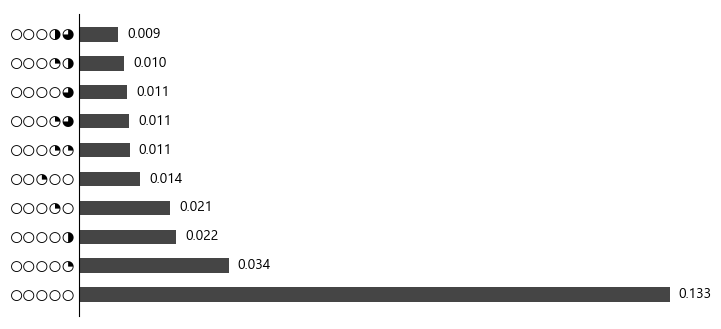

In [20]:
def autolabel(rects):    
    """
    Attach a text label left side of each bar displaying its width
    """
    for rect in rects:
        heigth = rect.get_height()
        width = rect.get_width()
        ax.text( width + .002, rect.get_y() + rect.get_height()/4,
                '%2.3f' % (width))
        
fig, ax = plt.subplots(1, 1,figsize=(8,4), dpi=100)
b = [item for sublist in (prob_frequent_patterns.iloc[:10,:].values) for item in sublist]
rects = ax.barh(np.arange(0,10),b, color='#454545',height=0.5, tick_label=prob_frequent_patterns.index[:10])
ax.tick_params(axis='y', labelsize = 11, which='major', pad=-1, rotation=0 , color = 'w')

ax.set_xticklabels([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

autolabel(rects)

### Plot heatmap of co-occurrence (coincidence) of power generation of each windfarm vs. other windfarms

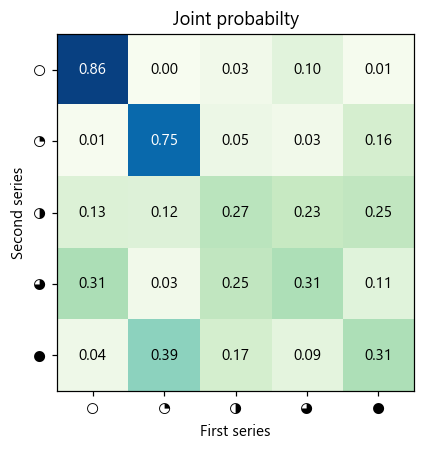

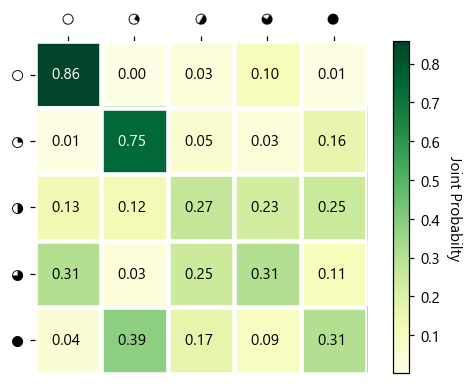

In [21]:
str1 = list(categorical_reps_df.iloc[:,0])
str2 = list(categorical_reps_df.iloc[:,1])

# Compute confusion matrix
cnf_matrix = confusion_matrix(str1, str2)
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis] #Normalize it
# print(cnf_matrix)
np.set_printoptions(precision=2)

fig, ax = plt.subplots(dpi=110) # figsize=(7,7)
plot_confusion_matrix(cnf_matrix, classes=alphabets, normalize=True, x_label='First series', y_label='Second series',
                      title='Joint probabilty', cmap = 'GnBu')

##########################################################################################################3
fig, ax = plt.subplots(dpi=110) # figsize=(7,7)

im, cbar = heatmap(cnf_matrix, alphabets, alphabets, cmap="YlGn", cbarlabel="Joint Probabilty")
texts = annotate_heatmap(im, valfmt="{x:.2f} ")  # >> this gives a warning
# fig.tight_layout()

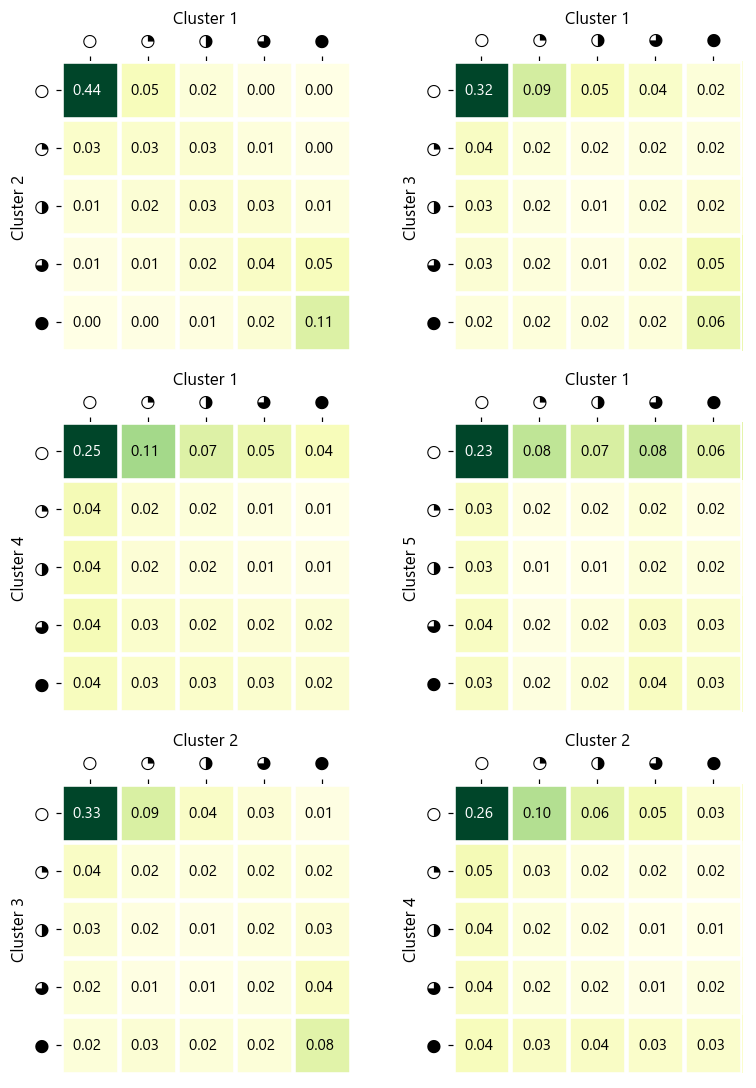

In [33]:
fig_n = 0; n_rows = 3; n_cols= 2; a = 0; b = 6
# fig_n = 1; n_rows = 2; n_cols= 2; a = 6; b=10

n_plots_figure = n_rows * n_cols
total_plots = 10

fig, axar = plt.subplots(n_rows, n_cols, figsize=(8,10), dpi = 110)
fig.subplots_adjust(hspace = 0.25, wspace = .15)

from itertools import combinations
combs = list(combinations(range(n_clusters),2))
ind = 0
for i in range(a, b): #n_plots_figure * fig_n , min(n_plots_figure*(fig_n + 1), total_plots)
    ind_0 = combs[i][0]
    ind_1 = combs[i][1]

    str1 = list(categorical_reps_df.iloc[:,ind_0])
    str2 = list(categorical_reps_df.iloc[:,ind_1])

    # Compute confusion matrix
    cnf_matrix = co_occurrence_matrix(str1,str2,alphabets) #confusion_matrix(str1, str2)
    #cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis] #Normalize it
    #print(sum(sum(cnf_matrix)))
    np.set_printoptions(precision=2)
    
    if n_cols ==1:
        ax = axar[ind]
    elif n_cols > 1:
        r = ind // n_cols
        c = ind % n_cols
        ax = axar[r, c] 
    ind += 1

    im = heatmap2(cnf_matrix, alphabets, alphabets, ax = ax, cmap="YlGn", cbarlabel="Joint Probabilty",
                        ind_0 = ind_0, ind_1 = ind_1)
    texts = annotate_heatmap2(im, valfmt="{x:.2f} ")  # >> this gives a warning
    fig.tight_layout()

# fig.savefig('Joint_probabilty_of_operation_of_two_clusters-fig{}.jpg'.format(fig_n), 
#         papertype='letter', dpi = 300, bbox_inches='tight')    

In [ ]:
# import matplotlib.image as mpimg

fig_n = 3; n_rows = 1; n_cols=2; a = fig_n*3*n_cols; b = 20#(fig_n+1)*n_rows*n_cols
# fig_n = 2; n_rows = 3; n_cols=2; a = fig_n*n_rows*n_cols; b = (fig_n+1)*n_rows*n_cols

n_plots_figure = n_rows * n_cols
# total_plots = 10

fig, axar = plt.subplots(n_rows, n_cols, figsize=(8,10), dpi = 100)
fig.subplots_adjust(hspace = 0.3, wspace = 0)

from itertools import combinations
combs = list(combinations(range(n_clusters),2))

ind = 0
for i in range(a, b): #n_plots_figure * fig_n , min(n_plots_figure*(fig_n + 1), total_plots)
    
    if n_cols ==1 or n_rows==1:
        ax = axar[ind]
    elif n_cols > 1:
        r = ind // n_cols
        c = ind % n_cols
        ax = axar[r, c] 
    ind += 1
    
    i2 = i // 2
    ind_0 = combs[i2][0]
    ind_1 = combs[i2][1]
    if ind % 2 != 0:
        str1 = list(categorical_reps_df.iloc[:,ind_0])
        str2 = list(categorical_reps_df.iloc[:,ind_1])
        # Compute confusion matrix
        cnf_matrix = co_occurrence_matrix(str1, str2,alphabets)
        # cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis] #Normalize it
        np.set_printoptions(precision=2)
        
        #ax.margins(6,9)
        im = heatmap2(cnf_matrix, alphabets, alphabets, ax = ax, cmap="YlGn", cbarlabel="Joint Probabilty",
                        ind_0 = ind_0, ind_1 = ind_1)
        texts = annotate_heatmap2(im, valfmt="{x:.2f} ")  # >> this gives a warning

    else:
        with matplotlib.cbook.get_sample_data('C:\\Mega\\+Experiments\\WindAnalysis\\MyCodes\\Plots\\windfarms_on_the_map\\windfarms_on_the_map_pair_of_clusters\\windfarms_5clusters_{}_{}_with_cluster_area_cropped.png'.format(ind_0,ind_1)) as image_file:
            image = plt.imread(image_file,)
        
        ax.margins(x=0, y=-0.25)
        ax.imshow(image)
        ax.axis('off')  # clear x-axis and y-axis

    fig.tight_layout()

# fig.savefig('Joint_prob_operation_two_clustered windfarms_with_map_fig{}_threerows.jpg'.format(fig_n), dpi = 300, bbox_inches='tight')    
